# About

This notebook combines NLP, machine learning and actuarial methods/knowledge to predict  the workers compensation insurance claims, see data source: https://www.kaggle.com/competitions/actuarial-loss-estimation/overview
It was a competition held by the Actuaries Institute of Australia, Institute and Faculty of Actuaries and the Singapore Actuarial Society.

This version focuses on using accident time for prediction. A study has revealed higher risk of worker injury for evening and night time (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3534259/).

And let's also explore other time elements of accident.

Development factor by year in v9 was kept but not used.

In [1]:
version = '_10'  #for file or path names
ver_nlp = '_7'  #for version of nlp.bin files only
autofix = False  #default False to disable auto spelling fix of claims description

In [2]:
import sklearn, pickle, time, os, pkg_resources
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, RepeatedKFold, RepeatedStratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression, TweedieRegressor
from sklearn.preprocessing import KBinsDiscretizer, LabelEncoder
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
import lightgbm as lgb
from lightgbm import LGBMRegressor
import xgboost as xgb
from xgboost import XGBRegressor
from symspellpy import SymSpell, Verbosity

In [3]:
book_start = time.time()

In [4]:
df = pd.read_csv('train.csv')
df_submit_test = pd.read_csv('test.csv')
dev_factor_yr = pd.read_csv('dev_factor.csv')   #from Actuarial_explore.ipynb
path_m = 'models'+version+'/'
model_list= []

In [5]:
# remove outlier, already checked
df=df.drop(df.index[11027])

In [6]:
def clean(df):
    #already check all claim numbers have prefix 'WC' followed by numbers
    df['ClaimNumber'] = df['ClaimNumber'].apply(lambda x: int(x[2:]))
    df['DateTimeOfAccident'] = pd.to_datetime(df['DateTimeOfAccident'], format='%Y-%m-%dT%H:%M:%SZ').astype('int')
    df['AccidentHour'] = pd.to_datetime(df['DateTimeOfAccident']).dt.hour
    df['AccidentDayofweek'] = pd.to_datetime(df['DateTimeOfAccident']).dt.dayofweek
    df['AccidentDayofmonth'] = pd.to_datetime(df['DateTimeOfAccident']).dt.daysinmonth
    df['AccidentMonth'] = pd.to_datetime(df['DateTimeOfAccident']).dt.month
    df['AccidentDayofyear'] = pd.to_datetime(df['DateTimeOfAccident']).dt.dayofyear
    df['DateReported'] = pd.to_datetime(df['DateReported'], format='%Y-%m-%dT%H:%M:%SZ').astype('int')
    #set category type in df for lightgbm to understand; treat missing catagory as another category
    for col in ['Gender', 'MaritalStatus', 'PartTimeFullTime']:
        df[col]=df[col].astype('category')
    # lightgbm does not need this step, but BayesSearch of sklearn needs; 
    # note: use label encoding for models that can assign categories, otherwise might be mistaken as numerical
    le = {}
    for col in ['Gender', 'MaritalStatus', 'PartTimeFullTime']:
        le[col] = LabelEncoder()
        df[col]= le[col].fit_transform(df[col])
    return df

In [7]:
def dev_factor(df):
    AccYear = pd.to_datetime(df['DateTimeOfAccident']).dt.year
    factor = AccYear.apply(lambda x: dev_factor_yr['dev_factor'][x-1986])
    return factor

In [8]:
dev_factor = df['UltimateIncurredClaimCost'].mean()/df['InitialIncurredCalimsCost'].mean()

def add1(df):
    df['claim_projected'] = df['InitialIncurredCalimsCost']*dev_factor
    df['time_lag'] =  df['DateReported'] - df['DateTimeOfAccident']
    return df

In [9]:
df = add1(clean(df))  #the order cannot be changed

#### Split data into train/test/val

In [10]:
# split data
split1, split2, seed = 0.2, 0.2, 42
X, y = {}, {}
X['all'] = df.drop(['UltimateIncurredClaimCost'], axis=1)
y['all'] = df['UltimateIncurredClaimCost']
X['train'], X['test'], y['train'], y['test'] = train_test_split(X['all'], y['all'], test_size=split1, random_state=seed)
X['train'], X['val'], y['train'], y['val'] = train_test_split(X['train'], y['train'], test_size=split2, random_state=seed)

X['cv'] = pd.concat([X['train'], X['val']])
y['cv'] = pd.concat([y['train'], y['val']])

In [11]:
def RMSE(estimator, X_test, y_test):
    pred_test_y = estimator.predict(X_test)
    return (sklearn.metrics.mean_squared_error(y_test, pred_test_y))**0.5

#### NLP Feature & Label Engineering
1) Workers compensation ultimate claim payments are usually a certain multiple of weekly wages, depending on the injury. Hence, the ratio of ultimate claims cost to weekly wages may reflect the injury factor. This can be a better label for claim description to learn to generate new feature, as claim description generally would not consider wage level. This also serves as a proxy to adjust for claims inflation. Then take log. Note: claims description usually won't contain information about claims inflation or be correlated with it, so it would be beneficial to get rid of claims inflation somehow for better alignment across years.

As some weekly wages are abnormally low and the workers compensation would also depend on future loss of income due to injury, these will be replaced by 100 in the calculation of injury_factor. 100 is half of 25% quartile.

In [12]:
Injury_factors = np.log(df['UltimateIncurredClaimCost']/df['WeeklyWages'].apply(lambda x: max(x, 100)))

In [13]:
Injury = np.array(Injury_factors).reshape(-1, 1)
#Injury = np.array(df['UltimateIncurredClaimCost']).reshape(-1, 1)

2) Let's create another feature to account for bias. Different types of claims may induce different levels of bias. As the bias can be extremely large due to its exponential distribution (see Actuarial_explore.ipynb), we compute the difference of log instead, which is equivalent to log of ratio. To correct abnormally low initial claims, set each to be at least 100 in this calculation.

In [14]:
Bias_factors = np.log(df['UltimateIncurredClaimCost']/df['InitialIncurredCalimsCost'].apply(lambda x: max(x, 100)))

In [15]:
Bias = np.array(Bias_factors).reshape(-1, 1)

#### K-Means clustering to categorize

#### 1) Injury

/Users/suenchihang/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:239: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(


[[2.]
 [2.]
 [1.]
 [3.]
 [2.]
 [1.]
 [0.]
 [2.]
 [0.]
 [0.]]


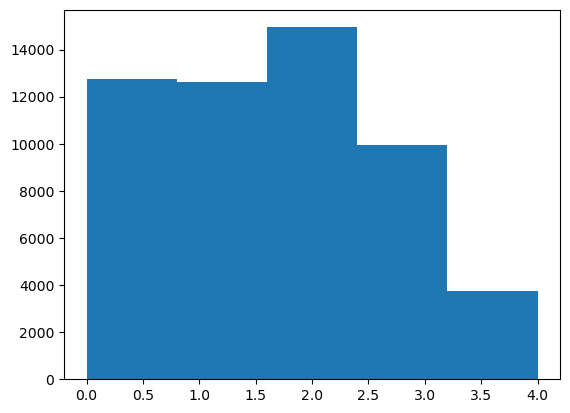

In [16]:
n_bins = 5

kbins = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='kmeans')
data_trans = kbins.fit_transform(Injury)
# summarize first few rows
print(data_trans[:10, :])
# histogram of the transformed data
plt.hist(data_trans, bins=n_bins)
plt.show()

In [17]:
for i in range(n_bins):
     # get row indexes for samples with this cluster
     row_ix = np.where(data_trans == i)
     print(f'cluster {i}: ')
     print(f'mean: {np.average(Injury[row_ix, 0]):.2f},  freq: {Injury[row_ix, 0].shape[1]}')
     print(f'range: {min(Injury[row_ix])} - {max(Injury[row_ix])}')
     print('------')

cluster 0: 
mean: 1.30,  freq: 12741
range: -1.1647002396536048 - 0.9189661171742141
------
cluster 1: 
mean: 1.87,  freq: 12617
range: 0.9191003618985188 - 2.0443439044651073
------
cluster 2: 
mean: 2.43,  freq: 14945
range: 2.0446688920737546 - 3.1108208655492455
------
cluster 3: 
mean: 2.93,  freq: 9935
range: 3.1109295568557727 - 4.372496743178632
------
cluster 4: 
mean: 3.69,  freq: 3761
range: 4.372860644462464 - 8.567341145942427
------


In [18]:
df['Injury_class'] = data_trans
# combine extreme classes, limit no of classes to at most 5
df['Injury_class'] = df['Injury_class'].apply(lambda x: int(min(x,4)))

#### 2) Bias

[[1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]]


/Users/suenchihang/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:239: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(


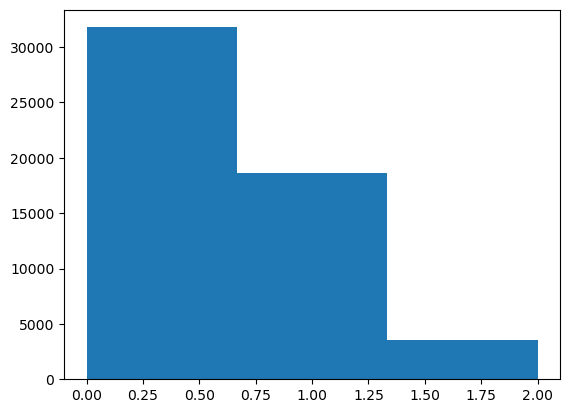

In [19]:
n_bins = 3

kbins = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='kmeans')
data_trans = kbins.fit_transform(Bias)
# summarize first few rows
print(data_trans[:10, :])
# histogram of the transformed data
plt.hist(data_trans, bins=n_bins)
plt.show()

In [20]:
for i in range(n_bins):
     # get row indexes for samples with this cluster
     row_ix = np.where(data_trans == i)
     print(f'cluster {i}: ')
     print(f'mean: {np.average(Bias[row_ix, 0]):.2f},  freq: {Bias[row_ix, 0].shape[1]}')
     print(f'range: {min(Bias[row_ix])} - {max(Bias[row_ix])}')
     print('------')

cluster 0: 
mean: 0.45,  freq: 31780
range: -3.131972418509273 - 0.21646972876270054
------
cluster 1: 
mean: 0.92,  freq: 18663
range: 0.21654707217291327 - 1.4836292858978188
------
cluster 2: 
mean: 1.71,  freq: 3556
range: 1.4837199600284563 - 6.721383221173538
------


In [21]:
df['Bias_class'] = data_trans
# combine extreme classes, limit no of classes to at most 5
df['Bias_class'] = df['Bias_class'].apply(lambda x: int(min(x,4)))

#### NLP packages / library

In [22]:
import fasttext as ft
from string import punctuation
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import nltk

In [23]:
nltk.download('punkt')
nltk.download('stopwords')
#creating objects for stopwords and PorterStemmer()
stop_words = nltk.corpus.stopwords.words('english')
stem = PorterStemmer()

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/suenchihang/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/suenchihang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [24]:
# load a dictionary (this one consists of 82,765 English words)
sym_spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)
dictionary_path = pkg_resources.resource_filename(
    "symspellpy", "frequency_dictionary_en_82_765.txt"
)
# term_index: column of the term 
# count_index: column of the term's frequency
sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)
def symspell_corrector(input_term):
  # look up suggestions for multi-word input strings 
  terms = sym_spell.lookup_compound( 
      phrase=input_term,  
      max_edit_distance=2,  
      transfer_casing=True,  
      ignore_term_with_digits=True, 
      ignore_non_words=True, 
      split_by_space=True 
  ) 
  return terms[0].term

In [25]:
def preprocess(text, autofix=autofix):
  if autofix:
      text = symspell_corrector(text)   
  words = word_tokenize(text)
  cleaned_words = [stem.stem(word.lower()) for word in words if word.lower() not in stop_words and word.lower() not in punctuation]
  words = ' '.join(cleaned_words)
  return words

In [26]:
df['text'] = df['ClaimDescription'].apply(preprocess)

In [27]:
# set df for engineered features

features_nlp = ['Injury_class','Bias_class']
df_nlp={}
for feature in features_nlp:
    df_nlp[feature] = {}
    df_nlp[feature]['all'] = '__label__' + df[feature].astype('str') + ' ' + df['text']

In [28]:
for feature in features_nlp:
    for dset in ['train', 'val', 'test']:
        df_nlp[feature][dset] = df_nlp[feature]['all'].loc[y[dset].index]
        df_nlp[feature][dset].to_csv('nlp_'+feature+'.'+dset, index = False, header = False)

In [29]:
print('_7'<'_9', '_7'<'_10')

True False


In [30]:
time_allowed = 900  #budget time in seconds for each NLP model
model_eng_nlp = {}
for feature in features_nlp:
    if ver_nlp == version:
        model_eng_nlp[feature] = ft.train_supervised(input='nlp_'+feature+'.train', autotuneValidationFile='nlp_'+feature+'.val', autotuneDuration=time_allowed)
        #model_eng_nlp[feature] = ft.train_supervised(input = 'nlp_'+feature+'.train', lr=0.2, epoch=100, wordNgrams=2)
    else:
        # else directly load model
        model_eng_nlp[feature] = ft.load_model('model_eng_nlp_'+feature+ver_nlp+'.bin')

In [31]:
if ver_nlp == version:
    for feature in features_nlp: 
        print(feature, '-------------------')
        for dset in ['val', 'test']:
            result = model_eng_nlp[feature].test('nlp_'+feature+'.'+dset)
            print(dset+' result: ', result)
            #save model for each feature
            model_eng_nlp[feature].save_model('model_eng_nlp_'+feature+ver_nlp+'.bin')

### Prepare dataset for NLP-engineering features

In [32]:
num_class, Classes = {}, {}
for feature in features_nlp: 
    num_class[feature] = len(np.unique(df[feature]))
    Classes[feature] = df['text'].apply(lambda x: model_eng_nlp[feature].predict(x, k=num_class[feature]))
    #df['Class'] = Classes_learnt.apply(lambda x: int(x[0][0][9:]))
    for i in range(num_class[feature]):    #class prob
        df[feature+str(i)] = Classes[feature].apply(lambda x: x[1][i])

X_nlp = {}
X_nlp['all'] = df.drop(['ClaimNumber', 'ClaimDescription', 'UltimateIncurredClaimCost', 'text'], axis=1)
X_nlp['all'].drop(features_nlp, axis=1, inplace=True)
print(X_nlp['all'].columns)

Index(['DateTimeOfAccident', 'DateReported', 'Age', 'Gender', 'MaritalStatus',
       'DependentChildren', 'DependentsOther', 'WeeklyWages',
       'PartTimeFullTime', 'HoursWorkedPerWeek', 'DaysWorkedPerWeek',
       'InitialIncurredCalimsCost', 'AccidentHour', 'AccidentDayofweek',
       'AccidentDayofmonth', 'AccidentMonth', 'AccidentDayofyear',
       'claim_projected', 'time_lag', 'Injury_class0', 'Injury_class1',
       'Injury_class2', 'Injury_class3', 'Injury_class4', 'Bias_class0',
       'Bias_class1', 'Bias_class2'],
      dtype='object')


In [33]:
def align_split(X_nlp):
    # assume key 'all' is whole set
    for dset in ['train', 'val', 'test']:
        X_nlp[dset] = X_nlp['all'].loc[y[dset].index]
    
    X_nlp['cv'] = pd.concat([X_nlp['train'], X_nlp['val']])
    return X_nlp

In [34]:
X_nlp = align_split(X_nlp)
print(X_nlp['cv'].columns)

Index(['DateTimeOfAccident', 'DateReported', 'Age', 'Gender', 'MaritalStatus',
       'DependentChildren', 'DependentsOther', 'WeeklyWages',
       'PartTimeFullTime', 'HoursWorkedPerWeek', 'DaysWorkedPerWeek',
       'InitialIncurredCalimsCost', 'AccidentHour', 'AccidentDayofweek',
       'AccidentDayofmonth', 'AccidentMonth', 'AccidentDayofyear',
       'claim_projected', 'time_lag', 'Injury_class0', 'Injury_class1',
       'Injury_class2', 'Injury_class3', 'Injury_class4', 'Bias_class0',
       'Bias_class1', 'Bias_class2'],
      dtype='object')


#### Train with NLP-engineering features

Use same feature search space except feature_fraction, as it was found to be 1 and actually we do not have many features.

#### Lightgbm

In [35]:
params_nlp = {
'num_leaves': Integer(8, 256),
'max_depth': Integer(1, 16),
'min_data_in_leaf': Integer(5, 300),
'min_gain_to_split': Real(0.01, 10000.0, prior='log-uniform'),
#'feature_fraction': Real(0.1, 1),
'lambda_l1': Real(0.01, 1000.0, prior='log-uniform'),
'lambda_l2': Real(0.01, 1000.0, prior='log-uniform'),
'learning_rate': Real(0.001, 1, prior='log-uniform'),
}

In [36]:
# define model
estimator = LGBMRegressor(task = 'train', objective = 'regression',)

In [37]:
# define evaluation
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=42)

In [38]:
def run_search(search, X_train, y_train):
    start=time.time()
    search.fit(X_train.to_numpy(), y_train.to_numpy())
    duration=time.time()-start
    return search, duration

def search_result(search, duration):
    print('time in seconds: ', duration)
    score = search.best_score_
    param = search.best_params_
    print('score: ', score)
    print(param)
    return param

In [39]:
search_nlp = BayesSearchCV(estimator=estimator, search_spaces=params_nlp, n_jobs=-1, cv=cv, scoring='neg_root_mean_squared_error')

In [40]:
# perform the search
search_nlp, duration = run_search(search_nlp, X_nlp['cv'], y['cv'])

[LightGBM] [Warning] min_data_in_leaf is set=259, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=259
[LightGBM] [Warning] min_data_in_leaf is set=259, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=259
[LightGBM] [Warning] lambda_l2 is set=0.014791025234911062, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.014791025234911062
[LightGBM] [Warning] lambda_l2 is set=0.014791025234911062, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.014791025234911062
[LightGBM] [Warning] min_gain_to_split is set=0.011653729203929137, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.011653729203929137[LightGBM] [Warning] min_gain_to_split is set=0.011653729203929137, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.011653729203929137

[LightGBM] [Warning] min_data_in_leaf is set=259, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=259[LightGBM] [Warning] lambda_l1 is set

In [41]:
# print and store result
param_nlp = search_result(search_nlp, duration)

time in seconds:  162.0390429496765
score:  -22889.03096893941
OrderedDict([('lambda_l1', 1000.0), ('lambda_l2', 0.01), ('learning_rate', 0.03982078313951752), ('max_depth', 5), ('min_data_in_leaf', 161), ('min_gain_to_split', 10000.0), ('num_leaves', 242)])


In [42]:
print('Testing RMSE: ', RMSE(search_nlp.best_estimator_, X_nlp['test'], y['test']))

Testing RMSE:  24555.860277601252


In [43]:
# save lgb model
if not os.path.exists(path_m):
    os.makedirs(path_m)
search_nlp.best_estimator_.booster_.save_model(path_m+"model_nlp_lgb.txt")

In [44]:
model_nlp_lgb = lgb.Booster(model_file=path_m+"model_nlp_lgb.txt")

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

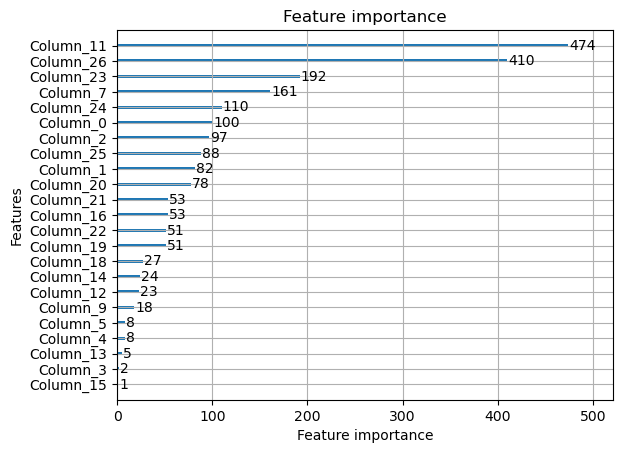

In [45]:
lgb.plot_importance(model_nlp_lgb)

In [90]:
pd.DataFrame(X_nlp['test'].columns)

,0
0,DateTimeOfAccident
1,DateReported
2,Age
3,Gender
4,MaritalStatus
5,DependentChildren
6,DependentsOther
7,WeeklyWages
8,PartTimeFullTime
9,HoursWorkedPerWeek


In [46]:
end_model1 = time.time()

## Optuna

Optuna is another tool for Bayesian optimization of hyperparameters. Let's see how much it might further improve the performance. Its advantages include ability to further optimize after optmization, scalability for large data, with visual tools. As it has integration with lightgbm, let's try it.

Reference:

https://optuna.readthedocs.io/en/stable/reference/generated/optuna.integration.lightgbm.LightGBMTuner.html

https://medium.com/optuna/lightgbm-tuner-new-optuna-integration-for-hyperparameter-optimization-8b7095e99258

In [48]:
start_optuna = time.time()

In [49]:
import optuna
import optuna.integration.lightgbm as optuna_lgb

/Users/suenchihang/opt/anaconda3/envs/py311/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [50]:
d_cv = optuna_lgb.Dataset(X_nlp['cv'], label=y['cv'])

params_optuna = {
    "objective": "regression",
    "metric": "rmse",
    "verbosity": -1,
    "boosting_type": "gbdt",
    "seed": 42,
}

study_tuner = optuna.create_study(direction='minimize')
optuna.logging.set_verbosity(optuna.logging.WARNING) 

[I 2023-07-14 07:12:47,401] A new study created in memory with name: no-name-70194a6c-e794-4de0-9c3a-2770b66dc611


In [51]:
tuner = optuna_lgb.LightGBMTunerCV(params_optuna, 
                            d_cv, 
                            study=study_tuner,
                            verbose_eval=False,                            
                            early_stopping_rounds=50,
                            time_budget=3600, # Time budget in seconds, we may not really need it
                            seed = 42,
                            folds= cv,
                            num_boost_round=10000,
                            return_cvbooster=True,
                            callbacks=[optuna_lgb.reset_parameter(learning_rate = [0.005]*200 + [0.001]*9800) ] #[0.1]*5 + [0.05]*15 + [0.01]*45 + 
                           )

start = time.time()
tuner.run()
duration = time.time() - start

feature_fraction, val_score: inf:   0%|                                                                                                      | 0/7 [00:00<?, ?it/s]/Users/suenchihang/opt/anaconda3/envs/py311/lib/python3.11/site-packages/lightgbm/engine.py:577: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/suenchihang/opt/anaconda3/envs/py311/lib/python3.11/site-packages/lightgbm/engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
feature_fraction, val_score: 23110.429561:  14%|############     

In [52]:
# print results
print(f'time in seconds: {duration:.2F}')
print(tuner.best_params)
print(tuner.best_score)

time in seconds: 3632.68
{'objective': 'regression', 'metric': 'rmse', 'verbosity': -1, 'boosting_type': 'gbdt', 'seed': 42, 'feature_pre_filter': False, 'lambda_l1': 0.0, 'lambda_l2': 0.0, 'num_leaves': 7, 'feature_fraction': 0.4, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 20}
22926.809482263554


In [53]:
model_optuna = tuner.get_best_booster()

In [54]:
pred_test_y = model_optuna.predict(X_nlp['test']) 

In [55]:
RMSE_list = []
for pred in pred_test_y: #model_optuna seems to have 30 sets of predictions  like CV
    RMSE_list.append( (sklearn.metrics.mean_squared_error(y['test'], pred))**0.5)
    print(RMSE_list[-1])

print('--------')
print(f'average testing RMSE: {np.average(RMSE_list):.2f}') 

24556.04595609815
24533.448772150557
24553.80094215167
24591.704040814828
24499.38904892574
24482.46739584643
24553.8100093961
24537.904235457725
24550.785731738935
24561.63668254971
24519.69563443667
24561.698921381183
24547.09600863898
24521.492663308974
24593.36555037303
24548.67959951161
24552.880414512412
24537.288677941793
24528.467108406676
24597.12677440197
24553.776714252854
24533.14726774499
24563.70464013599
24543.879767981343
24582.906208477743
24557.355725171954
24509.333323764087
24500.043747120235
24513.09482391688
24550.19939624887
--------
average testing RMSE: 24544.54


In [56]:
RMSE_avg = (sklearn.metrics.mean_squared_error(y['test'], np.average(pred_test_y, axis=0)))**0.5
print(f'Testing RMSE of average predictions:{RMSE_avg:.2f}')

Testing RMSE of average predictions:24530.62


#### Save & load

In [57]:
if not os.path.exists(path_m):
    os.makedirs(path_m)

In [58]:
model_optuna.save_model(path_m+'model_nlp_optuna.json')

In [59]:
loaded_model = lgb.Booster(model_file= path_m+'model_nlp_optuna.json')

In [60]:
# test the loaded model
pred_test_y = loaded_model.predict(X_nlp['test']) 
RMSE_avg = (sklearn.metrics.mean_squared_error(y['test'], pred_test_y))**0.5
print(f'Testing RMSE:{RMSE_avg:.2f}')

Testing RMSE:24550.20


#### Xgboost

In [61]:
estimator_xg = XGBRegressor()

In [62]:
params_xg = {}
#params_xg['n_estimators'] =   #increase in the last stage when no other further improvements
params_xg['max_depth'] = Integer(3, 18)
params_xg['eta'] = Real(0.001, 1, 'log-uniform')
params_xg['colsample_bytree'] = Real(0.5, 1)
params_xg['min_split_loss'] = Real(0.01, 10000, 'log-uniform')
params_xg['reg_alpha'] = Real(0.01, 10000, 'log-uniform')
params_xg['reg_lambda'] = Real(0.01, 10000, 'log-uniform')
params_xg['min_child_weight'] = Integer(0, 10)

In [63]:
search_xg = BayesSearchCV(estimator=estimator_xg, search_spaces=params_xg, n_jobs=-1, cv=cv, scoring='neg_root_mean_squared_error')
search_xg, duration = run_search(search_xg, X_nlp['cv'], y['cv'])

In [64]:
# print and store result
print('Cross validation results')
param_xg = search_result(search_xg, duration)

Cross validation results
time in seconds:  1524.8797519207
score:  -22902.576938701583
OrderedDict([('colsample_bytree', 0.5958362694251946), ('eta', 0.08317087968653601), ('max_depth', 3), ('min_child_weight', 10), ('min_split_loss', 0.01), ('reg_alpha', 0.01), ('reg_lambda', 80.21060866233742)])


In [65]:
print('____')
print('Testing RMSE: ', RMSE(search_xg.best_estimator_, X_nlp['test'], y['test']))
print('____')

____
Testing RMSE:  24534.619984374272
____


In [66]:
# save XGB
search_xg.best_estimator_.save_model(path_m+"model_nlp_xgb.txt")

#### Xgboost + Optuna

Ref: https://forecastegy.com/posts/xgboost-hyperparameter-tuning-with-optuna/#which-xgboost-hyperparameters-should-i-tune


In [67]:
def objective(trial):
    params = {
        "objective": "reg:squarederror",
        "early_stopping_rounds": 50,
        "n_estimators": 1000,
        "seed": 42,
        "verbosity": 0,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 20),
    }

    model = xgb.XGBRegressor(**params)
    model.fit(X_nlp['train'], y['train'], verbose=False, eval_set=[(X_nlp['train'], y['train']), (X_nlp['val'], y['val'])], )
    
    # Save a trained model to a file.
    path = path_m
    if not os.path.exists(path):
       os.makedirs(path)
    with open(path+"{}.pickle".format(trial.number), "wb") as fout:
        pickle.dump(model, fout)
    
    predictions = model.predict(X_nlp['val'])
    rmse = (sklearn.metrics.mean_squared_error(y['val'], predictions))**0.5
    return rmse

In [68]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)

In [69]:
print('Best hyperparameters:', study.best_params)
print('-----------------\n', 'Best RMSE:', study.best_value)

Best hyperparameters: {'learning_rate': 0.05642636690348236, 'max_depth': 2, 'subsample': 0.7541959832454823, 'colsample_bytree': 0.25183805536882015, 'min_child_weight': 9}
-----------------
 Best RMSE: 22503.83381973277


In [70]:
# Load the best model.
best_trial_num = study.best_trial.number
print('Best_trial number:', best_trial_num)
with open(path_m+"{}.pickle".format(best_trial_num), "rb") as fin:
    model_nlp_optuna_xgb = pickle.load(fin)
with open(path_m+"model_nlp_optuna_xgb_best.pickle".format(best_trial_num), "wb") as fout:
        pickle.dump(model_nlp_optuna_xgb, fout)

Best_trial number: 27


In [71]:
print('____')
print('Testing RMSE: ', RMSE(model_nlp_optuna_xgb, X_nlp['test'], y['test']))
print('____')

____
Testing RMSE:  24548.046419254846
____


#### Further exploration / analysis

In [72]:
model_complex_lgb = lgb.Booster(model_file= path_m+'model_nlp_optuna.json')

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

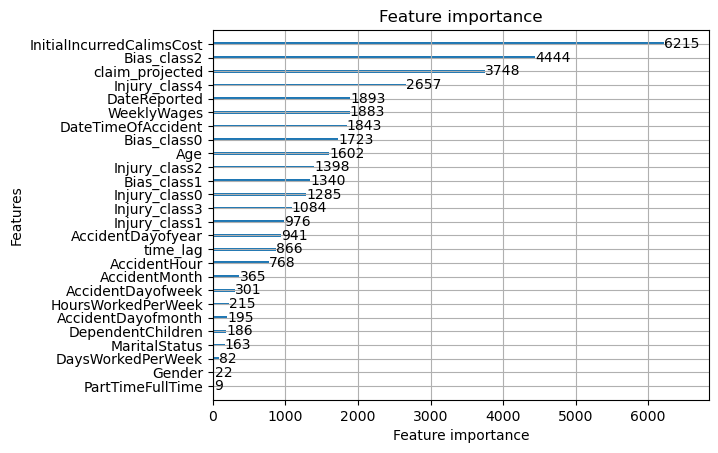

In [73]:
lgb.plot_importance(model_complex_lgb)

Insights: Date becomes useful predictor not just because of claims inflation nature, but because of the fact that after initial claim is used as predictor first, the residual tends to be correlated with date - because initial claim cost tends to be an under-estimate, not an unbiased predictor. Engineered feature 'Bias_class2' works well because the nature of gradient boosting algorithm is to predict residual (i.e. bias) after the first predictor is used.

<Axes: >

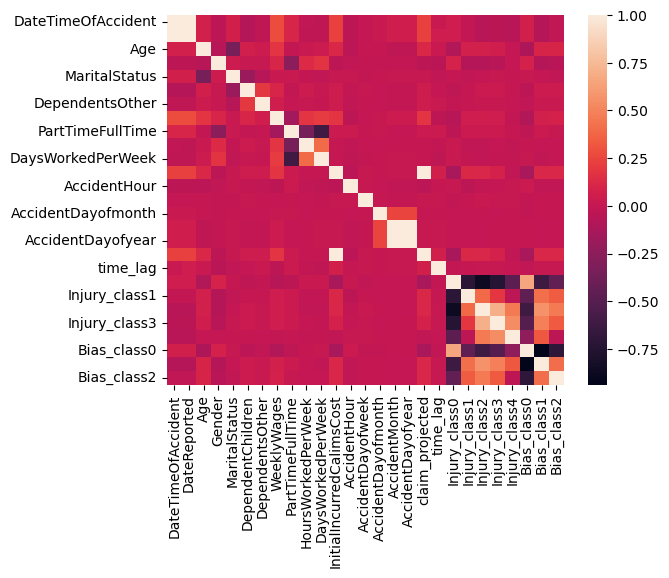

In [74]:
sns.heatmap(X_nlp['all'].corr())

In [75]:
model_list = [search_nlp.best_estimator_, model_complex_lgb, search_xg.best_estimator_, model_nlp_optuna_xgb]
RMSE_compare=[]
print('-----RMSE of Test------Compare models--------')
for idx, model in enumerate(model_list):
    RMSE_compare.append(RMSE(model, X_nlp['test'], y['test']))
    print(RMSE_compare[idx], model)

-----RMSE of Test------Compare models--------
24555.860277601252 LGBMRegressor(lambda_l1=1000.0, lambda_l2=0.01,
              learning_rate=0.03982078313951752, max_depth=5,
              min_data_in_leaf=161, min_gain_to_split=10000.0, num_leaves=242,
              objective='regression', task='train')
24550.19939624887 <lightgbm.basic.Booster object at 0x1806fd790>
24534.619984374272 XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.5958362694251946, early_stopping_rounds=None,
             enable_categorical=False, eta=0.08317087968653601,
             eval_metric=None, feature_types=None, gamma=None, gpu_id=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_

In [76]:
coefs, intercepts, rmse1, rmse2, R2 = [], [], [], [], []
print('coefficient, intercept, RMSE_val, RMSE_test, R2,     feature')
for i, col in enumerate(list(X_nlp['cv'].columns)):
    feature_cv = np.array(X_nlp['cv'][col]).reshape(-1,1)
    feature_test = np.array(X_nlp['test'][col]).reshape(-1,1)
    reg = LinearRegression().fit(feature_cv, y['cv']) #use cv as no tuning needed
    coefs.append(reg.coef_[0])
    intercepts.append(reg.intercept_)
    rmse1.append(RMSE(reg, feature_cv, y['cv']))
    rmse2.append(RMSE(reg, feature_test, y['test']))
    R2.append(reg.score(feature_test, y['test']))
    print(f'{coefs[i]:.3E}, {intercepts[i]:.3E}, {int(rmse1[i])},   {int(rmse2[i])},    {R2[i]:.3f}, {col}') 

coefficient, intercept, RMSE_val, RMSE_test, R2,     feature
3.174E-14, -1.622E+04, 27767,   29283,    0.035, DateTimeOfAccident
3.185E-14, -1.642E+04, 27762,   29278,    0.036, DateReported
2.674E+02, 1.788E+03, 28062,   29597,    0.015, Age
-2.078E+03, 1.244E+04, 28236,   29804,    0.001, Gender
3.316E+02, 1.061E+04, 28248,   29819,    -0.000, MaritalStatus
2.164E+03, 1.058E+04, 28227,   29794,    0.001, DependentChildren
7.129E+03, 1.076E+04, 28238,   29791,    0.002, DependentsOther
1.990E+01, 2.561E+03, 27812,   29302,    0.034, WeeklyWages
2.534E+03, 1.060E+04, 28240,   29806,    0.001, PartTimeFullTime
1.699E+01, 1.019E+04, 28248,   29821,    -0.000, HoursWorkedPerWeek
3.158E+02, 9.286E+03, 28248,   29822,    -0.000, DaysWorkedPerWeek
6.173E-01, 6.016E+03, 25242,   26077,    0.235, InitialIncurredCalimsCost
-2.338E+02, 1.354E+04, 28235,   29813,    0.000, AccidentHour
1.595E+02, 1.047E+04, 28248,   29817,    -0.000, AccidentDayofweek
2.704E+02, 2.603E+03, 28248,   29815,    -0.0

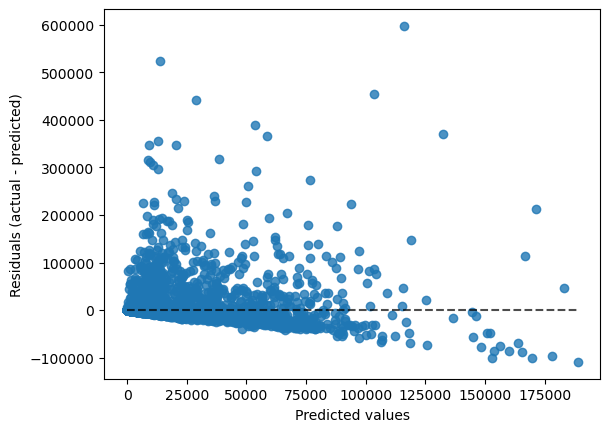

In [77]:
from sklearn.metrics import PredictionErrorDisplay
y_pred = model_complex_lgb.predict(X_nlp['test'])
display = PredictionErrorDisplay(y_true=y['test'], y_pred=y_pred)
display.plot()
plt.show()

### Submission to Kaggle

In [78]:
df_kaggle = pd.read_csv('test.csv')
df_k = df_kaggle.copy()

#### Pre-processing

In [79]:
df_k = add1(clean(df_k))

In [80]:
# NLP
#num_class = {....}  set manually if interrupted
for feature in features_nlp:
    model_eng_nlp[feature] = ft.load_model('model_eng_nlp_'+feature+ver_nlp+'.bin')
    cols = [feature+str(i) for i in range(num_class[feature])]
    df_k[feature+'_learnt'] = df_k['ClaimDescription'].apply(lambda x: model_eng_nlp[feature].predict(preprocess(x), k=num_class[feature])[1])
    df_k[cols] = pd.DataFrame(df_k[feature+'_learnt'].tolist(), index= df_k.index)

In [81]:
X_kaggle = df_k.drop(['ClaimNumber', 'ClaimDescription'], axis=1)  #no need to drop label as Kaggle test set has no label
X_kaggle.drop([feature+'_learnt' for feature in features_nlp], axis=1, inplace=True)
X_kaggle.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36000 entries, 0 to 35999
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   DateTimeOfAccident         36000 non-null  int64  
 1   DateReported               36000 non-null  int64  
 2   Age                        36000 non-null  int64  
 3   Gender                     36000 non-null  int64  
 4   MaritalStatus              36000 non-null  int64  
 5   DependentChildren          36000 non-null  int64  
 6   DependentsOther            36000 non-null  int64  
 7   WeeklyWages                36000 non-null  float64
 8   PartTimeFullTime           36000 non-null  int64  
 9   HoursWorkedPerWeek         36000 non-null  float64
 10  DaysWorkedPerWeek          36000 non-null  int64  
 11  InitialIncurredCalimsCost  36000 non-null  int64  
 12  AccidentHour               36000 non-null  int32  
 13  AccidentDayofweek          36000 non-null  int

#### Model & Submit

In [82]:
#load model
path = path_m+'model_nlp_optuna.json'
if os.path.exists(path):
    model_lgb_submit = lgb.Booster(model_file=path_m+'model_nlp_optuna.json')
else:
    model_lgb_submit = lgb.Booster(model_file=path_m+"model_nlp_lgb.txt")
#run model
yhat_kaggle = model_lgb_submit.predict(X_kaggle)
#convert to file
df_submit = pd.concat([df_kaggle['ClaimNumber'],pd.Series(yhat_kaggle, name='UltimateIncurredClaimCost', copy=True)], axis=1)
df_submit.to_csv('submit'+version+'.csv', encoding='utf-8', index=False)

In [83]:
print('OVERALL comment for version'+version+':')

OVERALL comment for version_10:


v10: try accident hour and other time elements

** from NLP_5, save lgb model for skopt as well; delete combine model section, leave it to a stage for meta learner later

In [84]:
#submit another model b

model_lgb_submit2 = lgb.Booster(model_file=path_m+"model_nlp_lgb.txt")
yhat_kaggle = model_lgb_submit2.predict(X_kaggle)
df_submit = pd.concat([df_kaggle['ClaimNumber'],pd.Series(yhat_kaggle, name='UltimateIncurredClaimCost', copy=True)], axis=1)
df_submit.to_csv('submit'+version+'b.csv', encoding='utf-8', index=False)

In [85]:
#submit another model x
model_xgb_submit = xgb.XGBRegressor()
model_xgb_submit.load_model(path_m+"model_nlp_xgb.txt")
yhat_kaggle = model_xgb_submit.predict(X_kaggle)
df_submit = pd.concat([df_kaggle['ClaimNumber'],pd.Series(yhat_kaggle, name='UltimateIncurredClaimCost', copy=True)], axis=1)
df_submit.to_csv('submit'+version+'x.csv', encoding='utf-8', index=False)

In [86]:
#submit another model xo
with open(path_m+"model_nlp_optuna_xgb_best.pickle", "rb") as fin:
    model_nlp_optuna_xgb = pickle.load(fin)
yhat_kaggle = model_nlp_optuna_xgb.predict(X_kaggle)
df_submit = pd.concat([df_kaggle['ClaimNumber'],pd.Series(yhat_kaggle, name='UltimateIncurredClaimCost', copy=True)], axis=1)
df_submit.to_csv('submit'+version+'xo.csv', encoding='utf-8', index=False)

In [87]:
book_end = time.time()

In [88]:
print(start_optuna-book_start)

175.08297681808472


In [89]:
print(book_end-book_start)

5507.17893075943
